In [1]:
import os
import pandas as pd
import nltk
import warnings
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from collections import Counter

warnings.filterwarnings("ignore")

### Data Load

In [2]:
folder_path = ["../datasets/new_shard_000", "../datasets/new_shard_001"]
save_path = "../datasets/merge_topic.csv"
data = []

for folder in folder_path:
    for file_name in tqdm(sorted(os.listdir(folder))):
        if file_name.endswith(".txt"):
            base = file_name.replace(".txt", "")
            txt_path = os.path.join(folder, file_name)
            img_path = os.path.join(folder, f"{base}.webp")
            img_name = f"{base}.webp"

        with open(txt_path, "r", encoding="utf-8") as f:
            text = f.read().strip()

        # 매칭된 이미지가 있으면 경로 기록
        img = img_name if os.path.exists(img_path) else None
        data.append({"text": text, "image_id": img})

df = pd.DataFrame(data)
df.to_csv(save_path, index=False)
df

100%|██████████| 175056/175056 [00:07<00:00, 24845.86it/s]


,text,image_id
0,"1other, 3boys, ancient greek clothes, arch, ba...",000_000000.webp
1,"1other, 3boys, ancient greek clothes, arch, ba...",000_000000.webp
2,"1girl, braid, brown hair, closed eyes, cowboy ...",000_000001.webp
3,"1girl, braid, brown hair, closed eyes, cowboy ...",000_000001.webp
4,"1boy, blonde hair, blue eyes, cloak, cropped t...",000_000002.webp
...,...,...
399995,"1girl, animal ear fluff, animal ears, black ba...",001_087525.webp
399996,"1girl, :o, animal ears, black shirt, blue cape...",001_087526.webp
399997,"1girl, :o, animal ears, black shirt, blue cape...",001_087526.webp
399998,"1girl, blazer, blush, braid, brown skirt, diag...",001_087527.webp


In [2]:
df = pd.read_csv("../datasets/merge_topic.csv")
df

,text,image_id
0,"1other, 3boys, ancient greek clothes, arch, ba...",000_000000.webp
1,"1other, 3boys, ancient greek clothes, arch, ba...",000_000000.webp
2,"1girl, braid, brown hair, closed eyes, cowboy ...",000_000001.webp
3,"1girl, braid, brown hair, closed eyes, cowboy ...",000_000001.webp
4,"1boy, blonde hair, blue eyes, cloak, cropped t...",000_000002.webp
...,...,...
399995,"1girl, animal ear fluff, animal ears, black ba...",001_087525.webp
399996,"1girl, :o, animal ears, black shirt, blue cape...",001_087526.webp
399997,"1girl, :o, animal ears, black shirt, blue cape...",001_087526.webp
399998,"1girl, blazer, blush, braid, brown skirt, diag...",001_087527.webp


### EDA

count    400000.000000
mean         60.798800
std          28.642495
min           6.000000
25%          42.000000
50%          55.000000
75%          73.000000
max         981.000000
Name: text, dtype: float64


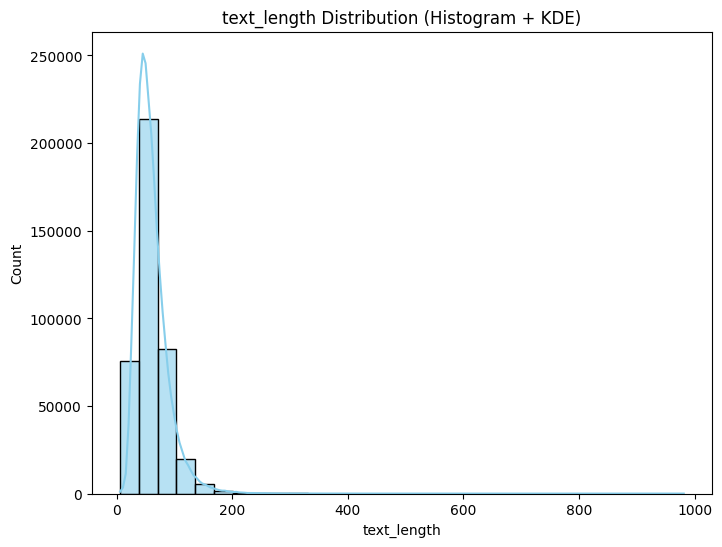

In [3]:
def create_text_length(df, text_col):
    lengths = df[text_col].apply(lambda x: len(str(x).split()))
    print(lengths.describe())
    return lengths

def hist_plot(df1, col, df2=None, figsize=(8, 6), bins=30, alpha=0.6, color1='skyblue', color2='salmon', label1=None, label2=None, title=None):
    plt.figure(figsize=figsize)
    sns.histplot(df1[col], kde=True, bins=bins, alpha=alpha, color=color1, label=label1 if label1 else ('Group 1' if df2 is not None else None))
    
    if df2 is not None: # 두 그룹 비교
        sns.histplot(df2[col], kde=True, bins=bins, alpha=alpha, color=color2, label=label2 if label2 else 'Group 2')
        plt.legend()  # 두 그룹일 때만 범례 표시

    plt.title(title if title else f'{col} Distribution (Histogram + KDE)')
    plt.xlabel(col)
    plt.show()

df['text_length'] = create_text_length(df, 'text')
hist_plot(df, "text_length", figsize=(8, 6))

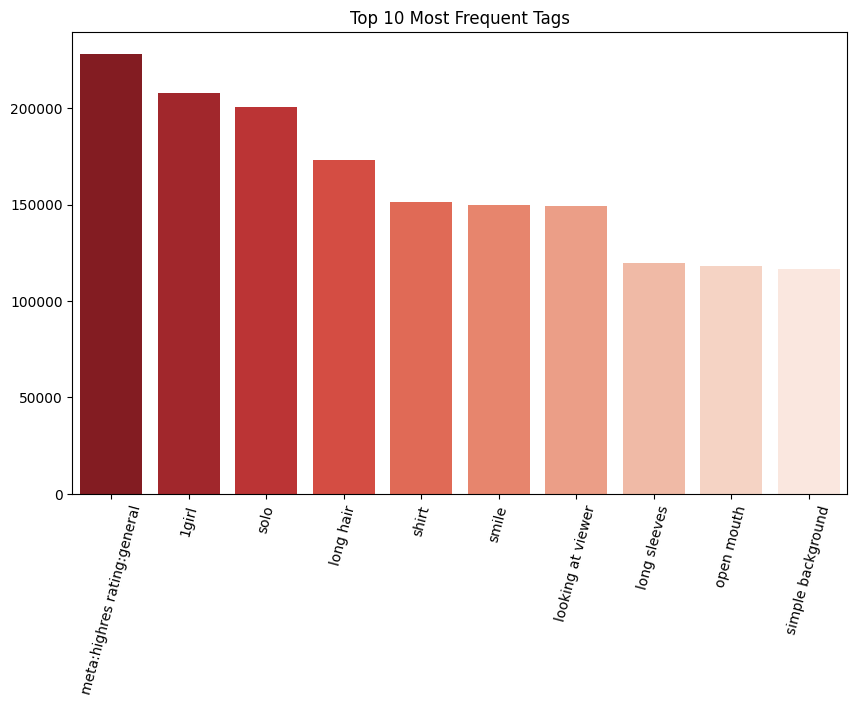

,tag,count
0,meta:highres rating:general,228054
1,1girl,207990
2,solo,200428
3,long hair,173120
4,shirt,151510
5,smile,149612
6,looking at viewer,149274
7,long sleeves,119622
8,open mouth,118164
9,simple background,116552


In [4]:
def bar_plot(df, x_col, y_col, figsize=(10, 6), hue=None, palette="Blues_r", rotation=None, title=None, xlabel=None, ylabel=None):
     plt.figure(figsize=figsize)
     if hue: # hue 지정
        sns.barplot(x=x_col, y=y_col, hue=hue, data=df, palette=palette)
     else: # hue 지정 X
        sns.barplot(x=x_col, y=y_col, data=df, palette=palette)
     plt.xticks(rotation=rotation)
     plt.title(title)
     plt.xlabel(xlabel)
     plt.ylabel(ylabel)
     plt.show()

def tag_cnt(df, col:str, number:int=10, mode:str='top'):
   all_tags = []
   for text in df[col]:
      tags = [tag.strip() for tag in text.split(',')]
      all_tags.extend(tags)
   tag_counts = Counter(all_tags)
      
   if mode == 'top':
      selected_tags = tag_counts.most_common(number)
   elif mode == 'low':
      all_tags_sorted = tag_counts.most_common()
      selected_tags = all_tags_sorted[-number:][::-1]

   tag_df = pd.DataFrame(selected_tags, columns=['tag', 'count'])
   return tag_df

tag_df = tag_cnt(df, col='text', number=10, mode='top')
bar_plot(tag_df, 'tag', 'count', title='Top 10 Most Frequent Tags', rotation=75, palette="Reds_r")
tag_df

### Data preprocessing

In [5]:
def metadata_cnt(df, text_col:str='text', check_list:list=None):
      prefix_counts = {prefix: 0 for prefix in check_list}
      for text in df[text_col]:
          tags = [tag.strip() for tag in text.split(',')]
          for tag in tags:
              for prefix in check_list:
                  if tag.startswith(prefix):
                      prefix_counts[prefix] += 1
                      break
      return prefix_counts

check_list = ['meta:', 'rating:', 'artist:', 'character:', 'series:', 'copyright:']
metadata = metadata_cnt(df, text_col='text', check_list=check_list)
metadata

{'meta:': 885398,
 'rating:': 0,
 'artist:': 400960,
 'character:': 759480,
 'series:': 594238,
 'copyright:': 0}

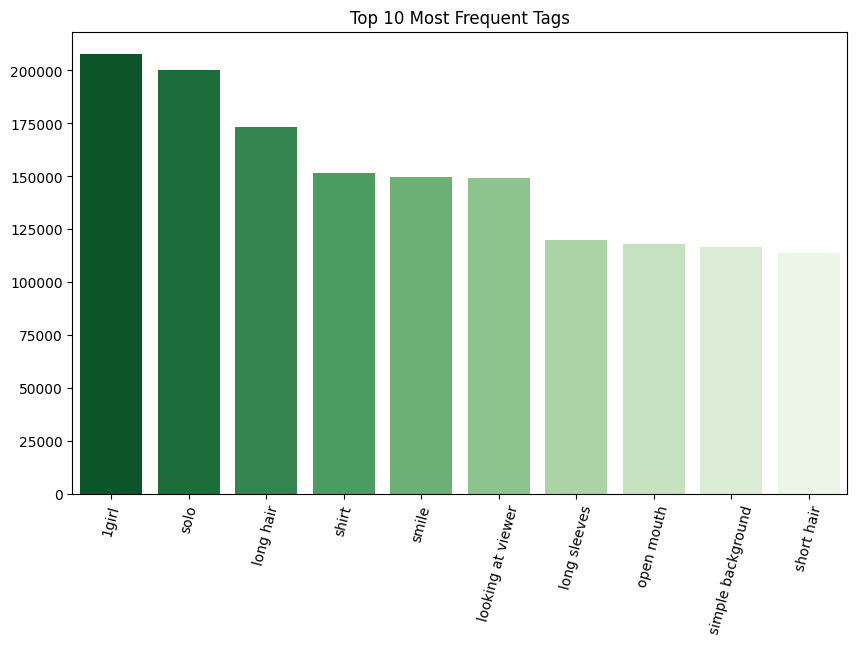

,tag,count
0,1girl,207990
1,solo,200428
2,long hair,173120
3,shirt,151510
4,smile,149612
5,looking at viewer,149274
6,long sleeves,119622
7,open mouth,118164
8,simple background,116552
9,short hair,113884


In [5]:
def clean_text(text, drop_list:list):
    tags = [tag.strip() for tag in text.split(',')]
    filter_tags = []
    for tag in tags:
        if not any(prefix in tag for prefix in drop_list):
            filter_tags.append(tag)
    return ', '.join(filter_tags)

drop_list = ['meta', 'highres', 'rating', 'general']
df['clean_text'] = df['text'].apply(clean_text, drop_list=drop_list)
df = df[['image_id', 'text', 'clean_text', 'text_length']]
clean_tag = tag_cnt(df, col='clean_text', number=10, mode='top')
bar_plot(clean_tag, 'tag', 'count', title='Top 10 Most Frequent Tags', rotation=75, palette="Greens_r")
clean_tag

In [7]:
# low_10 = tag_cnt(df, col='clean_text', number=10, mode='low')
# bar_plot(low_10, 'tag', 'count', title='Low 10 Most Frequent Tags', rotation=75)
# low_10